# Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# Loading Data

In [2]:
ghi_dir="C:\\Users\\srisa\\Desktop\\PV doctor assignment\\GHI"
pr_dir="C:\\Users\\srisa\\Desktop\\PV doctor assignment\\PR"

# Data Preprocessing

## Combining Mainfolders With Subfolders

In [3]:
def combining_data(main_folder):
    combined_data=pd.DataFrame()
    for subfolder in os.listdir(main_folder):
        subfolder_path=os.path.join(main_folder,subfolder)    
        if os.path.isdir(subfolder_path):
            for csv_file in os.listdir(subfolder_path):
                csv_path=os.path.join(subfolder_path,csv_file)   
                if csv_file.endswith('.csv'):
                    temp_df=pd.read_csv(csv_path)
                    combined_data = pd.concat([combined_data,temp_df],ignore_index=True)
    return combined_data

In [4]:
ghi_df=combining_data(ghi_dir)
ghi_df

,Date,GHI
0,2019-07-01,3.256608
1,2019-07-02,3.976767
2,2019-07-03,2.811867
3,2019-07-04,3.658408
4,2019-07-05,5.590683
...,...,...
977,2022-03-20,4.226183
978,2022-03-21,3.431675
979,2022-03-22,3.580492
980,2022-03-23,4.997617


In [5]:
pr_df=combining_data(pr_dir)
pr_df

,Date,PR
0,2019-07-01,69.575676
1,2019-07-02,79.314411
2,2019-07-03,61.020006
3,2019-07-04,83.262576
4,2019-07-05,82.124440
...,...,...
977,2022-03-20,81.632738
978,2022-03-21,71.057353
979,2022-03-22,81.631509
980,2022-03-23,71.906149


## Merging Two DataFrames on Date

In [6]:
final_df=pd.merge(ghi_df,pr_df,on="Date",how="inner")

In [7]:
final_df

,Date,GHI,PR
0,2019-07-01,3.256608,69.575676
1,2019-07-02,3.976767,79.314411
2,2019-07-03,2.811867,61.020006
3,2019-07-04,3.658408,83.262576
4,2019-07-05,5.590683,82.124440
...,...,...,...
977,2022-03-20,4.226183,81.632738
978,2022-03-21,3.431675,71.057353
979,2022-03-22,3.580492,81.631509
980,2022-03-23,4.997617,71.906149


In [8]:
final_df["Date"]=pd.to_datetime(final_df["Date"])

In [9]:
final_df=final_df.sort_values('Date')

In [10]:
final_df

,Date,GHI,PR
0,2019-07-01,3.256608,69.575676
1,2019-07-02,3.976767,79.314411
2,2019-07-03,2.811867,61.020006
3,2019-07-04,3.658408,83.262576
4,2019-07-05,5.590683,82.124440
...,...,...,...
977,2022-03-20,4.226183,81.632738
978,2022-03-21,3.431675,71.057353
979,2022-03-22,3.580492,81.631509
980,2022-03-23,4.997617,71.906149


In [11]:
final_df.shape

(982, 3)

In [12]:
final_df.isnull().sum()

Date    0
GHI     0
PR      0
dtype: int64

In [13]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    982 non-null    datetime64[ns]
 1   GHI     982 non-null    float64       
 2   PR      982 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 23.1 KB


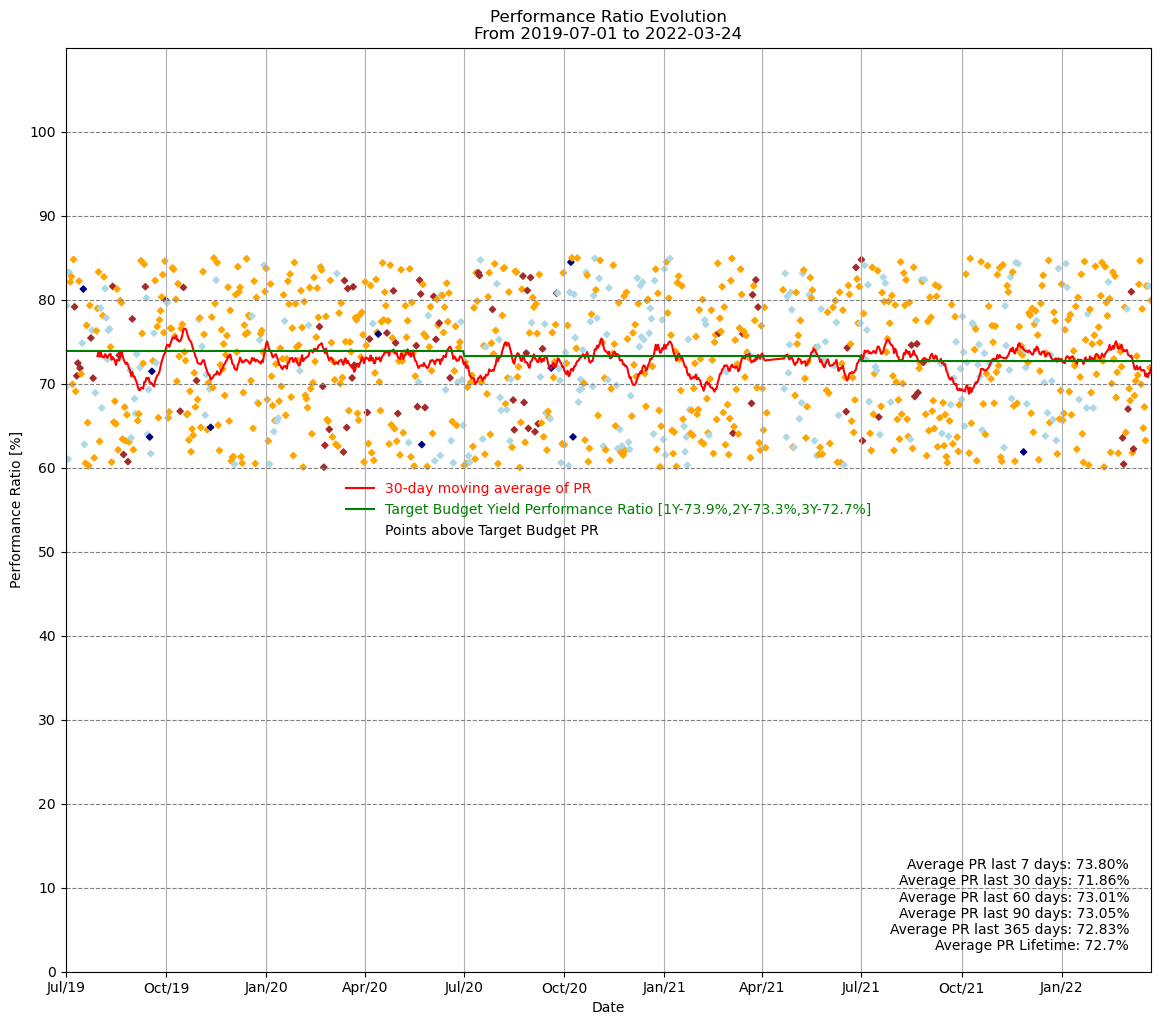

In [23]:
def generate_graph(final_df, start_date='2019-07-01', end_date='2022-03-24'):
    final_df['30d_MA_PR'] = final_df['PR'].rolling(window=30).mean()
    final_df['Year'] = pd.DatetimeIndex(final_df['Date']).year
    final_df['Month'] = pd.DatetimeIndex(final_df['Date']).month
    final_df['Day'] = pd.DatetimeIndex(final_df['Date']).day
    budget_line = []
    for i, row in final_df.iterrows():
        if row['Year'] == 2019 and row['Month'] >= 7 or row['Year'] == 2020 and row['Month'] < 7:
            budget_line.append(73.9)
        elif row['Year'] == 2020 and row['Month'] >= 7 or row['Year'] == 2021 and row['Month'] < 7:
            budget_line.append(73.9 - 0.6)
        else:
            budget_line.append(73.9 - 1.2)
    final_df['Budget'] = budget_line
    plt.figure(figsize=(14, 12))
    colors = {0: 'navy', 1: 'lightblue', 2: 'orange', 3: 'brown'}
    ghi_bins = [0, 2, 4, 6, np.inf]
    final_df['GHI_bin'] = pd.cut(final_df['GHI'], bins=ghi_bins, labels=[0, 1, 2, 3])
    scatter = plt.scatter(final_df['Date'], final_df['PR'], c=final_df['GHI_bin'].map(colors), marker='D', s=10)
    
    # Plot lines with specific colors
    line1, = plt.plot(final_df['Date'], final_df['30d_MA_PR'], color='red', label='30-day moving average of PR')
    line2, = plt.plot(final_df['Date'], final_df['Budget'], color='green', label='Target Budget Yield Performance Ratio [1Y-73.9%,2Y-73.3%,3Y-72.7%]')
    
    above_budget = final_df[final_df['PR'] > final_df['Budget']]
    plt.scatter(above_budget['Date'], above_budget['PR'], color='none', marker='D', s=10, label='Points above Target Budget PR')
    
    avg_prs = {
        "Average PR last 7 days": final_df['PR'].tail(7).mean(),
        "Average PR last 30 days": final_df['PR'].tail(30).mean(),
        "Average PR last 60 days": final_df['PR'].tail(60).mean(),
        "Average PR last 90 days": final_df['PR'].tail(90).mean(),
        "Average PR last 365 days": final_df['PR'].tail(365).mean(),
        "Average PR Lifetime": final_df['PR'].mean()
    }
    textstr = '\n'.join((
        f"Average PR last 7 days: {avg_prs['Average PR last 7 days']:.2f}%",
        f"Average PR last 30 days: {avg_prs['Average PR last 30 days']:.2f}%",
        f"Average PR last 60 days: {avg_prs['Average PR last 60 days']:.2f}%",
        f"Average PR last 90 days: {avg_prs['Average PR last 90 days']:.2f}%",
        f"Average PR last 365 days: {avg_prs['Average PR last 365 days']:.2f}%",
        f"Average PR Lifetime: {avg_prs['Average PR Lifetime']:.1f}%"
    ))
    plt.text(0.98, 0.02, textstr, transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment="right")
    
    # Customizing the legend
    legend = plt.legend(loc='center', frameon=False, fontsize=10)
    
    # Change color of specific legend labels
    legend.get_texts()[0].set_color('red')   # 30-day moving average of PR
    legend.get_texts()[1].set_color('green') # Target Budget Yield Performance Ratio

    plt.title('Performance Ratio Evolution\nFrom 2019-07-01 to 2022-03-24')
    plt.xlabel('Date')
    plt.ylabel('Performance Ratio [%]')
    plt.ylim(0, 110)
    plt.yticks(np.arange(0, 101, 10))
    plt.grid(axis='y', linestyle='--', color='gray')
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))
    plt.xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
    
    plt.grid(True)
    plt.show()

# Assuming final_df is already defined
generate_graph(final_df, start_date='2019-07-01', end_date='2022-03-24')